In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
game_df = pd.read_csv('game.csv')
game_info_df = pd.read_csv('game_info.csv')

In [3]:
game_merge_df = pd.merge(game_info_df, game_df, on='game_id', how='left')
game_merge_df.drop('game_date_y', axis=1, inplace=True)
game_merge_df.rename(columns={'game_date_x': 'game_date'}, inplace=True)

In [4]:
game_merge_df = game_merge_df[game_merge_df['season_id'] >= 22001]

In [5]:
game_merge_df.head()

,game_id,game_date,attendance,game_time,season_id,team_id_home,team_abbreviation_home,team_name_home,matchup_home,wl_home,...,dreb_away,reb_away,ast_away,stl_away,blk_away,tov_away,pf_away,pts_away,plus_minus_away,video_available_away
36369,20100005,2001-10-30 00:00:00,18697.0,2:08,22001,1610612750,MIN,Minnesota Timberwolves,MIN vs. PHI,W,...,26.0,41.0,16.0,4.0,6.0,21.0,20.0,74,-9,0
36370,20100012,2001-10-30 00:00:00,18997.0,2:30,22001,1610612747,LAL,Los Angeles Lakers,LAL vs. POR,W,...,37.0,42.0,17.0,10.0,7.0,15.0,28.0,87,-11,0
36371,20100004,2001-10-30 00:00:00,16088.0,2:26,22001,1610612753,ORL,Orlando Magic,ORL vs. TOR,W,...,16.0,38.0,17.0,13.0,3.0,21.0,29.0,85,-29,0
36372,20100007,2001-10-30 00:00:00,9500.0,2:41,22001,1610612745,HOU,Houston Rockets,HOU vs. ATL,W,...,37.0,47.0,15.0,10.0,8.0,17.0,26.0,84,-5,0
36373,20100008,2001-10-30 00:00:00,16803.0,2:13,22001,1610612759,SAS,San Antonio Spurs,SAS vs. LAC,W,...,31.0,42.0,9.0,11.0,3.0,18.0,31.0,98,-11,0


In [6]:
home_wins = game_merge_df[game_merge_df['wl_home'] == 'W'].shape[0]
home_losses = game_merge_df[game_merge_df['wl_home'] == 'L'].shape[0]

away_wins = game_merge_df[game_merge_df['wl_away'] == 'W'].shape[0]
away_losses = game_merge_df[game_merge_df['wl_away'] == 'L'].shape[0]

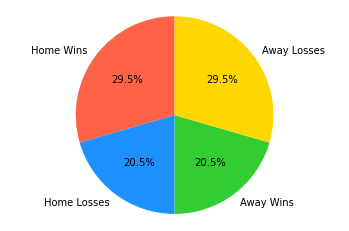

In [12]:
# Pie chart data
labels = ['Home Wins', 'Home Losses', 'Away Wins', 'Away Losses']
sizes = [home_wins, home_losses, away_wins, away_losses]
colors = ['#FF6347', '#1E90FF', '#32CD32', '#FFD700']

# Plot pie chart
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')

# Display the pie chart
plt.show()

In [15]:
season_group = game_merge_df.groupby('season_id')
win_rate_per_season = season_group['wl_home'].apply(lambda x: (x == 'W').sum() / x.count())

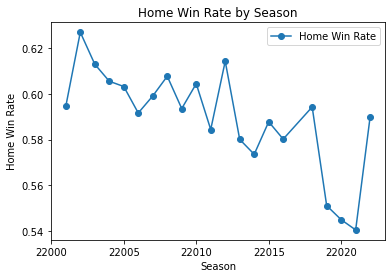

In [17]:
fig, ax = plt.subplots()

# Plot a line chart
ax.plot(win_rate_per_season.index, win_rate_per_season, marker='o', linestyle='-', label='Home Win Rate')

# Plot an area chart (uncomment the following line to use an area chart)
# ax.fill_between(win_rate_per_season.index, win_rate_per_season, color='skyblue', alpha=0.5, label='Home Win Rate')

# Customize the chart
ax.set_xlabel('Season')
ax.set_ylabel('Home Win Rate')
ax.set_title('Home Win Rate by Season')
ax.legend()

# Display the chart
plt.show()